In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
import dataset_miscnd
import space
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 100
TRAIN_SIZE  = 0.7
NOISE       = 0.#05
MESH_SIZE   = 100

POPSIZE          = 500
MAX_STREE_DEPTH  = 8
MAX_STREE_LENGTH = 20
GENERATIONS      = 50
GROUP_SIZE       = 5  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 40000
LIB_MAXDEPTH  = 5
LIB_MAXLENGTH = 15

RANDSTATE = None#124

In [3]:
randstate.setstate(RANDSTATE)

#S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc3d.Resistance3()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
S = dataset_physics.RocketFuelFlow()
#S = dataset_physics.AircraftLift()
#S = dataset_misc2d.Pagie1()
#S = dataset_miscnd.WavePower()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
import profiling
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

const_prob = 0.0 if S.knowledge.has_symmvars() else 0.5
solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars, const_prob=const_prob)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

mesh           = space.MeshSpace(S_train, S.knowledge, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, mesh)
data_evaluator = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, data_evaluator, know_pressure=0.0)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
profiling.enable()
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)
profiling.disable()

settings = gp.GPSettings(
      POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
      creator=solutionCreator,
      evaluator=evaluator,
      selector=selector,
      crossover=crossover,
      mutator=multiMutator,
      corrector=corrector,
      mutrate=MUTATION_RATE,
      elitism=ELITISM,
      knowledge=S.knowledge)
symb_regressor = gp.GP(settings)
#symb_regressor = gp.MOGP(settings)

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

#profiling.print_stats()

test_data_evaluator = gp_evaluator.R2Evaluator(S_test)
best_stree.clear_output()
print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
print(f"Test R2: {test_data_evaluator.evaluate(best_stree).value}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/49 [00:00<?, ?it/s]

CHILD DIFF RATIO: 0.9877638669421822

1.00 1.00 (x0 * ((x1 / 24.74) / sqrt(x2)))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt(x2)))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt(x2)))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt(x2)))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt(x2)))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt(x2)))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt(x2)))
1.00 1.00 (((x1 * x0) / 24.74) / sqrt((0.00 + x2)))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt((0.00 + x2))))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt((0.00 + x2))))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt((0.00 + x2))))
1.00 1.00 (((x1 / 24.74) / sqrt((0.00 + x2))) * x0)
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt((0.00 + x2))))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt((0.00 + x2))))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt((0.00 + x2))))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt((0.00 + x2))))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt((0.00 + x2))))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt((0.00 + x2))))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt((0.00 + x2))))
1.00 1.00 (x0 * ((x1 / 24.74) / sqrt(

In [5]:
"""n = corrector.symm_n + corrector.asymm_n + corrector.lib_n
print(f"SYMM: {corrector.symm_n/n}")
print(f"ASYMM: {corrector.asymm_n/n}")
print(f"LIB: {corrector.lib_n/n}")"""

'n = corrector.symm_n + corrector.asymm_n + corrector.lib_n\nprint(f"SYMM: {corrector.symm_n/n}")\nprint(f"ASYMM: {corrector.asymm_n/n}")\nprint(f"LIB: {corrector.lib_n/n}")'

In [6]:
#profiling.print_stats()

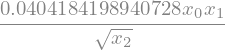

In [7]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

In [8]:
best_stree.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
S.evaluate_extra(best_stree)  #'(sqrt((x2 * ((x1 * x0) * 0.00))) * 0.00)'

{'mse': 3.4479361333880017e-25, 'rmse': 5.871912919473518e-13, 'r2': 1.0}

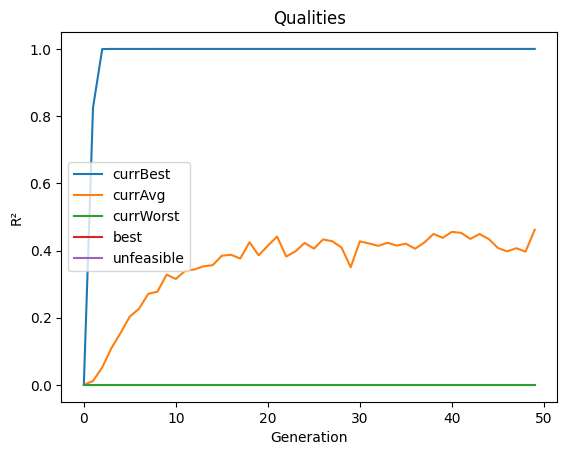

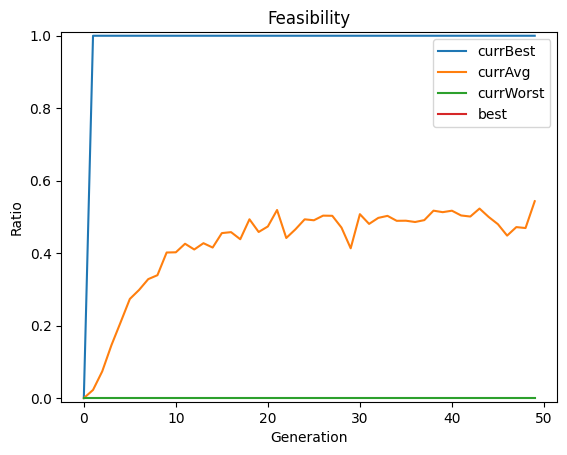

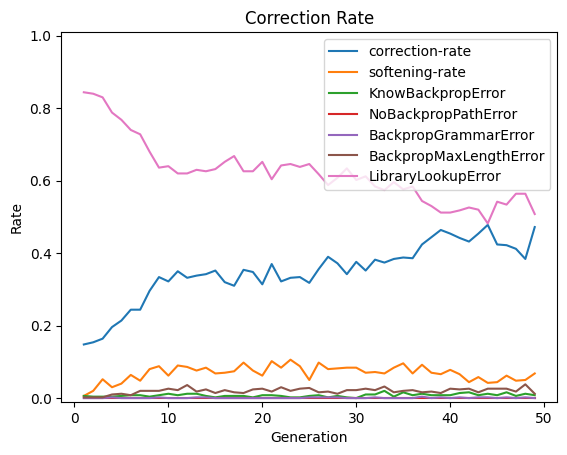

In [9]:
symb_regressor.stats.plot()

In [ ]:
pd_data = []
front_tracker, fea_ratio = symb_regressor.fea_front_tracker.get_head(0)

for frontidx in range(len(front_tracker.front)):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

data_lu = (0.0,1.0)
length_lu = (1,MAX_STREE_LENGTH)

front_tracker.plot(data_lu, length_lu, 0)
print(f"Feasibility Ratio: {fea_ratio}")
print(f"Extent of Convergence: {front_tracker.compute_extend_of_convergence(data_lu, length_lu)}")
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)